# Importing packages

In [70]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from skimage.transform import resize
from skimage.io import imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Preparing the dataset

In [3]:
tags_path = os.path.join('D:/Kaggle_Datasets/Amazon uderstanding/train_v2.csv')
image_path = os.path.join(('D:/Kaggle_Datasets/Amazon uderstanding/train-jpg/train-jpg'))

In [4]:
# Function creating a mapping of tags to integers
def tag_mapping(tag_csv):
    
    tags_ = set()
    for i in range(len(tag_csv)):
        
        # To get each tag
        tags = tag_csv['tags'][i].split(' ')
        tags_.update(tags)   # To add only a single argument
    
    # To sort tags, so convert to list
    tags_ = list(tags_)   
    tags_.sort()
    
    # To determine every tag with the key number 
    tags_map = {tags_[i]:i for i in range(len(tags_))}
    return tags_map

In [5]:
# Function creating a mapping of filename to integers
def file_mapping(tag_csv):
    
    f_map = {}
    for i in range(len(tag_csv)):
        filename = tag_csv['image_name'][i]
        tag_name = tag_csv['tags'][i]
        
        f_map[filename] = tag_name.split(' ')
        
    return f_map

In [6]:
# create a one hot encoding for one list of tags
def one_hot_encoding(tags, filename_mapping):

    # create empty vector
    oh_encoding = np.zeros(len(filename_mapping), dtype='uint8')
    
    # mark 1 for each tag in the vector
    for tag in tags:
        oh_encoding[filename_mapping[tag]] = 1
        
    return oh_encoding

In [7]:
# To load the dataset (images and tags)
def make_dataset(path, file_mapping, tag_mapping):

    images = [] 
    targets = []
    
    for filename in tqdm(os.listdir(path)):
        
        # load image 
        img = load_img(path + '/' + filename, target_size=(128,128))
        
        # convert to numpy array
        img = img_to_array(img, dtype='uint8')
        
        # To obtaing all tags
        tags = file_mapping[filename[:-4]]
        
        # To encode all tags
        target = one_hot_encoding(tags, tag_mapping)
        
        images.append(img)
        targets.append(target)
        
    X = np.asarray(images, dtype='uint8')
    Y = np.asarray(targets, dtype='uint8')
    
    return X, Y

In [8]:
# load the mapping file
filename = 'D:/Kaggle_Datasets/Amazon uderstanding/train_v2.csv'
tag_csv = pd.read_csv(tags_path)
 
tags_mapping =tag_mapping(tag_csv)

filename_mapping = file_mapping(tag_csv)

# loading the images with jpg format
folder = image_path
X, Y = make_dataset(folder, filename_mapping, tags_mapping)

print('X shape is:', X.shape) 
print('Y shape is:', Y.shape)

100%|██████████| 2520/2520 [00:24<00:00, 104.13it/s]


X shape is: (2520, 128, 128, 3)
Y shape is: (2520, 17)


In [9]:
# To separate training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1764, 128, 128, 3)
x_test shape: (756, 128, 128, 3)
y_train shape: (1764, 17)
y_test shape: (756, 17)


# Convolutional Neural Network model

# 1- CNN model witout Dropout and Image Augmentation

The structure of the basic CNN model including:
    
1- The Convolutional layer is to extract features

2- The Pooling layer to reduce the number of features and avoid to overfitting

3- The Flatten layer is equal to reshape of data

4- The dense layer is the classifier

In [13]:
# Set CNN model

model = Sequential()

# Convolutional block 1
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional block 2
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional block 3
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# For multilabel classification, use sigmoid because softmax is useful for mutually exclusive classes
model.add(Dense(17, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=64)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)     

To evaluate training

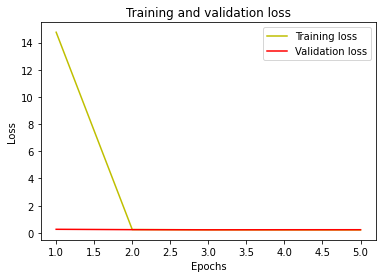

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

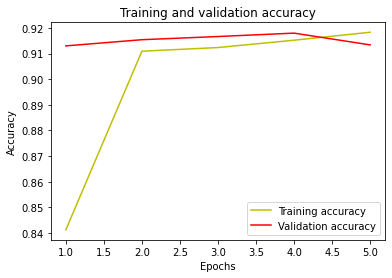

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Score = ", score[0])
print("Test Accuracy = ", score[1])

Test Score =  0.23023904450040647
Test Accuracy =  0.9133986234664917


In [60]:
# Predict model
predictions = model.predict(x_test)

In [18]:
# Save model
model.save('D:/cnn_base_model.h5')
print("Model is saved")

Model is saved


# 2- CNN model with Dropout Regularization and Batchnormalization

In order to reduce overfitting, we can use dropout regularization.
To get more information about Dropout Regularization, visit this website: 
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

In [27]:
# Set model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# Classifier
model.add(Dense(17, activation='sigmoid'))

model.summary()

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)       

To evaluate training

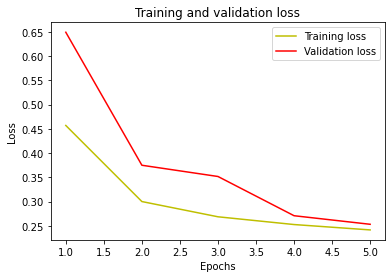

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

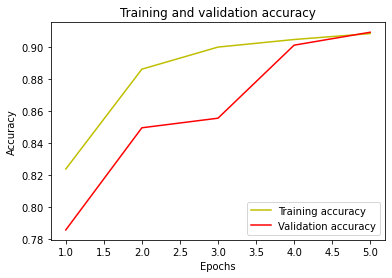

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Score = ", score[0])
print("Test Accuracy = ", score[1])

Test Score =  0.25320616995216044
Test Accuracy =  0.909274697303772


In [32]:
# Predict model
predictions = model.predict(x_test)

In [33]:
# Save model
model.save('D:/cnn_model_dropout.h5')
print("Model is saved")

Model is saved


# 3- CNN model with Dropout and Data Augmentation

Image Augmentation with Image Data generator:
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

Using data augmentation technique, we can create new data modified the existing data.
In this case, the puprose of data aumentation is to reduce overfiting

In [35]:
# Create generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Prepare iterators 
train_iterator = datagen.flow(x_train, y_train, batch_size=128)
test_iterator = datagen.flow(x_test, y_test, batch_size=128)

In [37]:
# Set up model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit model
history = model.fit_generator(train_iterator, steps_per_epoch = len(train_iterator), epochs = 5, 
                              validation_data = test_iterator,
                              validation_steps = len(test_iterator),
                              verbose = 1)

# Evaluate model
loss, acc = model.evaluate_generator(test_iterator, steps = len(test_iterator), verbose = 1)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 128)      

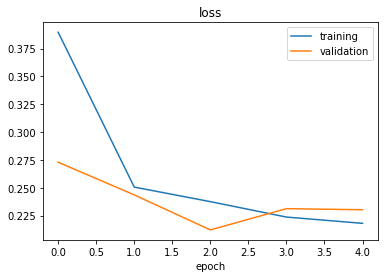

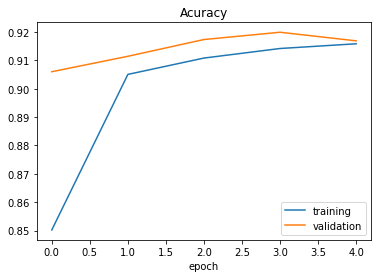

In [40]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acuracy')
plt.xlabel('epoch')

plt.show()

In [38]:
# Predict model
predictions = model.predict_generator(test_iterator, steps = len(test_iterator))

In [46]:
# Save model
model.save('D:/cnn_dataAugmented_model.h5')
print("Model is saved")

Model is saved


# 4- Transfer learning-Build Fine-tuned VGG16 model

In [14]:
# Set VGGNet
vggmodel = VGG16(include_top=False, input_shape=(128, 128, 3))

# We do not want to train this layer again, we do not update:
for layer in vggmodel.layers:
    layer.trainable = False
    
flat_layer = Flatten()(vggmodel.layers[-1].output)
dense_layer = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat_layer)
output_layer = Dense(17, activation='sigmoid')(dense_layer)

# Set a new model
newmodel = Model(inputs=vggmodel.inputs, outputs=output_layer) 

# compile the new model
optimizer = SGD(lr=0.01, momentum=0.9)
newmodel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

newmodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [15]:
# Fit the model and check the accuracy
transfer_model = newmodel.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_data=(x_test, y_test))
loss, acc = newmodel.evaluate(x_test, y_test, verbose=1)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


Train on 1764 samples, validate on 756 samples
Epoch 1/5
1764/1764 [==============================] - 3258s 2s/step - loss: 0.6565 - accuracy: 0.8633 - val_loss: 0.3709 - val_accuracy: 0.9159
Epoch 2/5
1764/1764 [==============================] - 3214s 2s/step - loss: 0.2582 - accuracy: 0.9299 - val_loss: 0.2421 - val_accuracy: 0.9327
Epoch 3/5
1764/1764 [==============================] - 3202s 2s/step - loss: 0.1709 - accuracy: 0.9417 - val_loss: 0.1964 - val_accuracy: 0.9312
Epoch 4/5
1764/1764 [==============================] - 3211s 2s/step - loss: 0.1291 - accuracy: 0.9522 - val_loss: 0.1786 - val_accuracy: 0.9392
Epoch 5/5
756/756 [==============================] - 971s 1s/step

Testing loss: 0.17973821212059607, acc: 0.9382198452949524



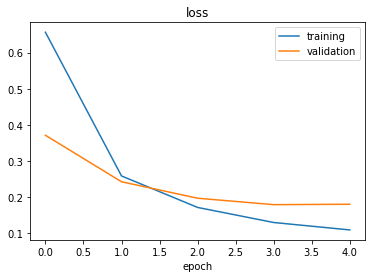

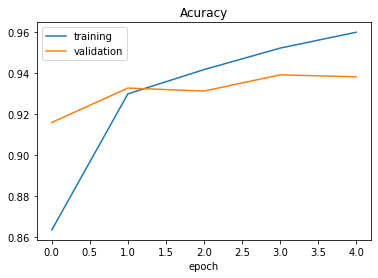

In [19]:
plt.figure(1)
plt.plot(transfer_model.history['loss'])
plt.plot(transfer_model.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(transfer_model.history['accuracy'])
plt.plot(transfer_model.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acuracy')
plt.xlabel('epoch')

plt.show()

# Saving the model as h5 file

In [24]:
# 1- Save model using pickle
import pickle

with open("D:/transfer_learning_vgg16", "wb") as file:
    pickle.dump(transfer_model, file)

In [23]:
# 2- Save model using keras
newmodel.save('D:/transfer_model.h5')
print("Model is saved")

Model is saved


# Loading the saved model

In [66]:
from keras.models import load_model
 
# load model
model = load_model('D:/saved model/cnn_dataAugmented_model.h5')
# summarize model.
#model.summary()

# Comapre the results of trained models

In [53]:
models = ['cnn_base_model', 'cnn_model_dropout', 'cnn_dataAugmented_model', 'transfer_model']

val_loss = [0.2302, 0.2532, 0.2302 , 0.1797]
val_accuracy = [0.9134, 0.9093, 0.9169, 0.9382]

dic = {'Models': models, 'Validation loss': val_loss, 'Validation accuracy': val_accuracy}

df_models = pd.DataFrame.from_dict(dic, orient='index')
df_models.transpose()

,Models,Validation loss,Validation accuracy
0,cnn_base_model,0.2302,0.9134
1,cnn_model_dropout,0.2532,0.9093
2,cnn_dataAugmented_model,0.2302,0.9169
3,transfer_model,0.1797,0.9382


# Model Metrics

Three metrics to evaluate the classification accuracy of neural network, which are being used commonly, incldue:

1- Precision

2- Recall

3- F1 Score

In [67]:
# Evaluate augmnented model result

# Predict the probability
y_probs = model.predict(x_test, verbose=0)
# Predict each class
y_classes = model.predict_classes(x_test, verbose=0)

In [75]:
# y_test should convert to single-digit ones from one-hot-encoded
predictions = np.argmax(y_test, axis=1)

In [94]:
def cal_accuracy(predictions, y_classes):
    
    # precision tp / (tp + fp)
    # 'average' parameter is required for multiclass/multilabel targets
    precision = precision_score(predictions, y_classes, average='weighted')
    print('Precision score is : {}'.format(precision))
    
    # recall: tp / (tp + fn)
    recall = recall_score(predictions, y_classes, average='weighted')
    print('Recall score is : {}'.format(recall))
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(predictions, y_classes, average='weighted')
    print('f1 score is : {}'.format(f1))
    
    return precision, recall, f1

In [95]:
metrics = cal_accuracy(predictions, y_classes) 
print(metrics)

Precision score is : 0.4824673637328266
Recall score is : 0.1917989417989418
f1 score is : 0.22338708100709745
(0.4824673637328266, 0.1917989417989418, 0.22338708100709745)
